In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('LogReg_titanic').getOrCreate()

In [3]:
df = spark.read. csv('titanic.csv', inferSchema = True, header = True)

In [4]:
df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [5]:
# Feature Selection:
# X = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
# y = ['Survived']

# check string features for classess
df.select('Pclass').distinct().show() # onehotencoding
df.select('Sex').distinct().show() # stringIndexer + onehotencoding
# SibSp variance is retain
# Parch variance is retain
print (df.select('Fare').distinct().count() , df.count()) # variance is retain
df.select('Embarked').distinct().show() # stringIndexer + onehotencoding
# features - stringIndexer + onehotencoding: Sex', 'Embarked'
# features - onehotencoding: 'Pclass'

+------+
|Pclass|
+------+
|     1|
|     3|
|     2|
+------+

+------+
|   Sex|
+------+
|female|
|  male|
+------+

248 891
+--------+
|Embarked|
+--------+
|       Q|
|    null|
|       C|
|       S|
+--------+



In [6]:
data = df.select('Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived').na.drop()

Machine Learning

- Step # 1: Load Libraries
- Step # 2: Pipeline Stages
- Step # 3: Pipeline Train
- Step # 4: Pipeline Test
- Step # 5: Model Evaluation

In [7]:
# Load Libralies

from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [8]:
# Pipeline Stages

# StringIndexer
gender_indexer = StringIndexer(inputCol='Sex', outputCol='SexIndex')
embark_indexer = StringIndexer(inputCol='Embarked', outputCol='EmbarkIndex')

# Encoding
gender_encoder = OneHotEncoder(inputCol='SexIndex', outputCol='SexVec')
embark_encoder = OneHotEncoder(inputCol='EmbarkIndex', outputCol='EmbarkVec')
pclass_encoder = OneHotEncoder(inputCol='Pclass', outputCol='PclassVec')

# Assembler
assembler = VectorAssembler(
    inputCols= ['PclassVec', 'SexVec', 'Age', 'SibSp', 'Parch', 'Fare', 'EmbarkVec'],
    outputCol='features')

# Machine Learning
log_reg_titanic = LogisticRegression(featuresCol='features',labelCol='Survived')

In [9]:
# Pipeline Train
pipeline = Pipeline(stages=[gender_indexer,embark_indexer,
                           gender_encoder,embark_encoder,pclass_encoder,
                           assembler,log_reg_titanic])

train_data, test_data = data.randomSplit([0.7,.3])
fit_model = pipeline.fit(train_data)

In [10]:
# Pipeline Test

result = fit_model.transform(test_data)

In [11]:
# Model Evaluation

from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [12]:
my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Survived')

In [13]:
AUC = my_eval.evaluate(result)
print ("Area under ROC:",round(AUC,2))

Area under ROC: 0.77


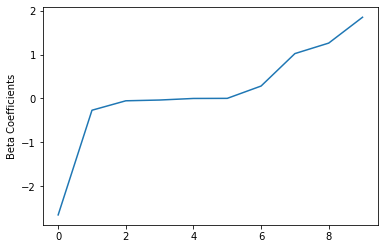

In [17]:
lrModel = fit_model.stages[-1]

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

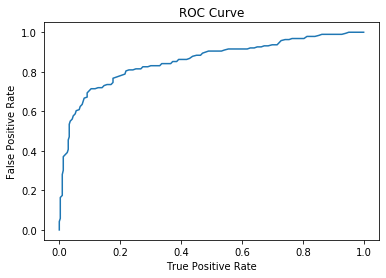

Training set area Under ROC: 0.86


In [15]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set area Under ROC: ' + str(round(trainingSummary.areaUnderROC,2)))

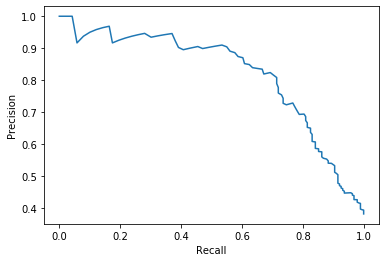

In [16]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()